# Lecture 10

#### V. Hunter Adams (vha3), MAE 4160/5160, Spring 2020

In [1]:
from IPython.display import Latex
from IPython.display import Image
from IPython.core.display import HTML

## Command and Data Handling (C&DH)

The command and data handling subsystem, also known as **avionics** or **on-board processing** includes all of the flight computers, flight electronics, and flight software on a spacecraft. This is a particularly cross-cutting subsystem since, on modern spacecraft, it interfaces with nearly every other subsystem. This is also a subystem that, perhaps more than any other, has evolved since the early days of space exploration. It's worth spending some time on the history of flight electronics in order to appreciate this development.

## Apollo Flight Computer

Each Apollo command module and lunar lander carried an Apollo Guidance Computer (AGC) which provided computation and electronic interfaces for the guidance, navigation, and control of the spacecraft. The astronauts interacted with this computer via a numerical display and keyboard called the "DSKY" ("display and keyboard"). The computer casing is shown below left, and the DSKY below right.

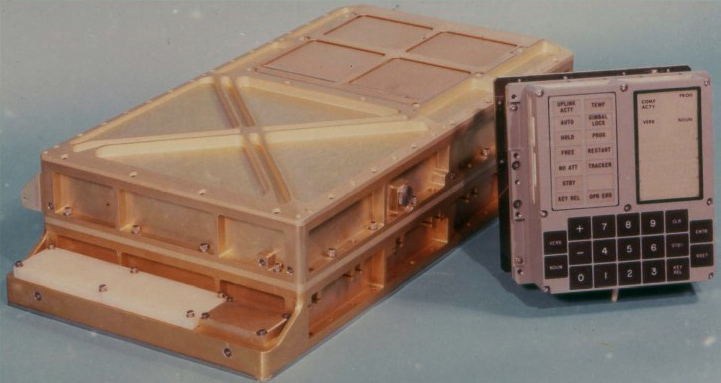

In [2]:
Image("oldschool.jpg", width=400)

The DSKY interface:

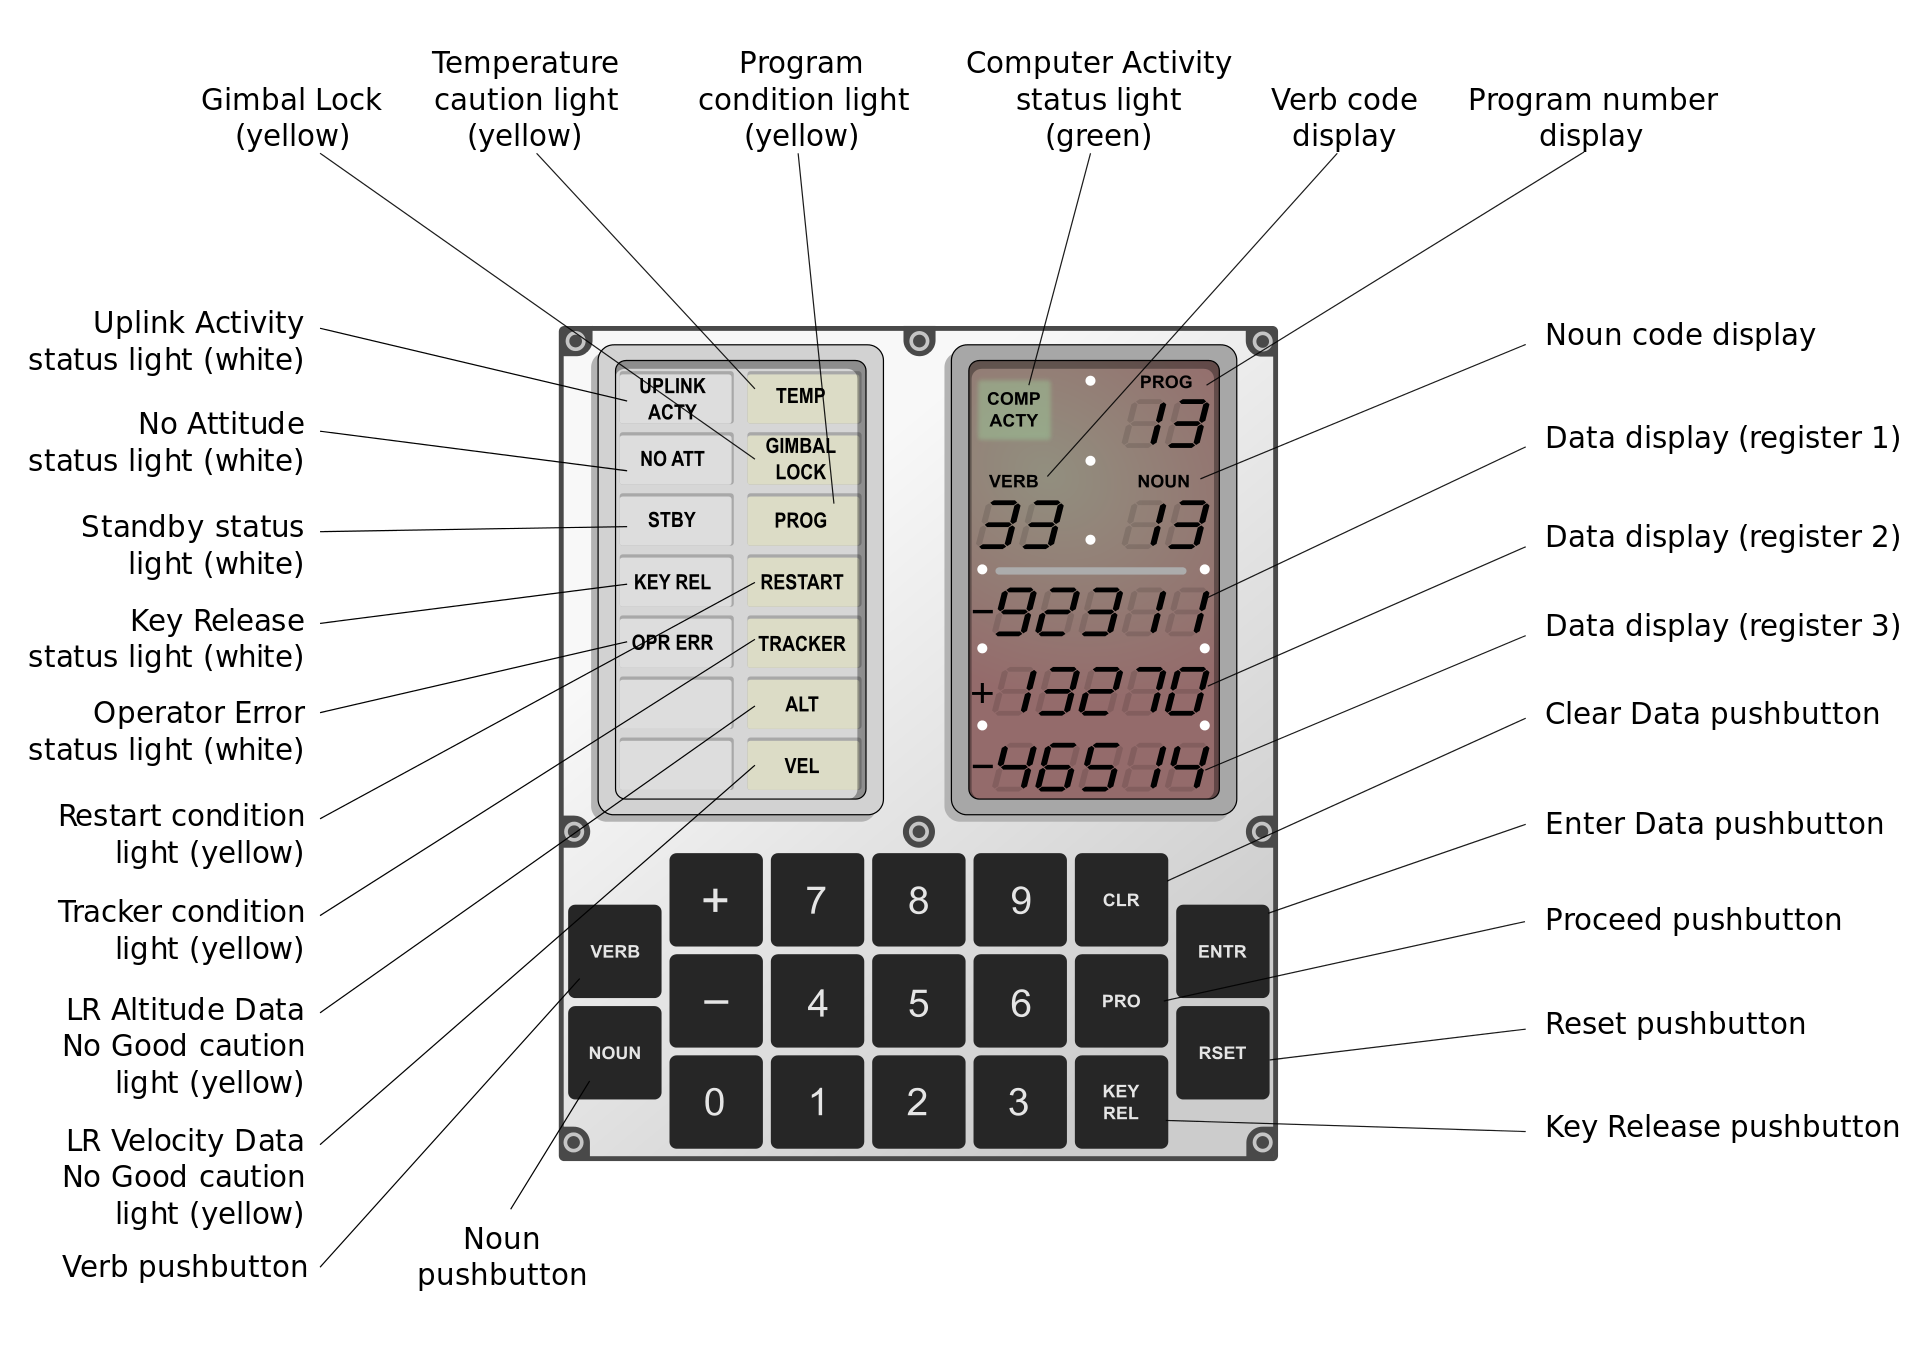

In [4]:
Image("dsky.png", width=400)

Some stats:
1. 16-bit word length (14 bits + sign + parity)
2. Memory cycle time: 11.7 microsec
3. Add time: 23.4 microsec
4. Multiply time: 46.8 microsec
5. Divide time: 81.9 microsec
6. Memory: 36,864 words (ROM), 2,048 words (RAM)
7. 34 normal instructions
8. 55 Watts
9. 70 lbs

Think about this. The flight computer had only 2048 words (4096 bytes) of RAM. This is the part of the memory that was being manipulated for doing guidance, navigation, and control calculations. Is it clear why recursive estimation algorithms like the Extended Kalman Filter were a necessity for Apollo? You can go on Wikipedia and read about every register in this computer, and see the exhaustive list of commands that one could send to the computer (it's not a long list).

The RAM memory was magnetic core memory. The ROM was built on core rope memory. Bits were stored by magnetication of tiny toroids of wire, hand-woven. The picture below is the ROM memory for the Apollo computer.

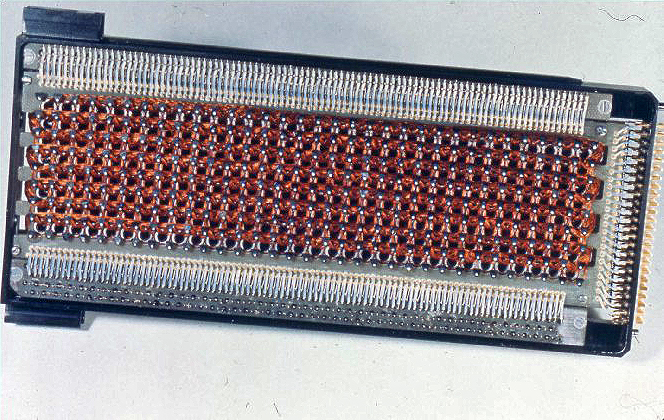

In [5]:
Image("rope.jpg", width=400)

The software for the flight computer (the GNC algorithms, for example) was stored in this rope-core memory, which was programmed in assembly language. The computer ran a very simple realtime operating system and an interrupt-driven preemptive scheduler. The team that implemented the flight software was led by Margaret Hamilton, who later received a Presidential Medal of Freedom for her contributions.

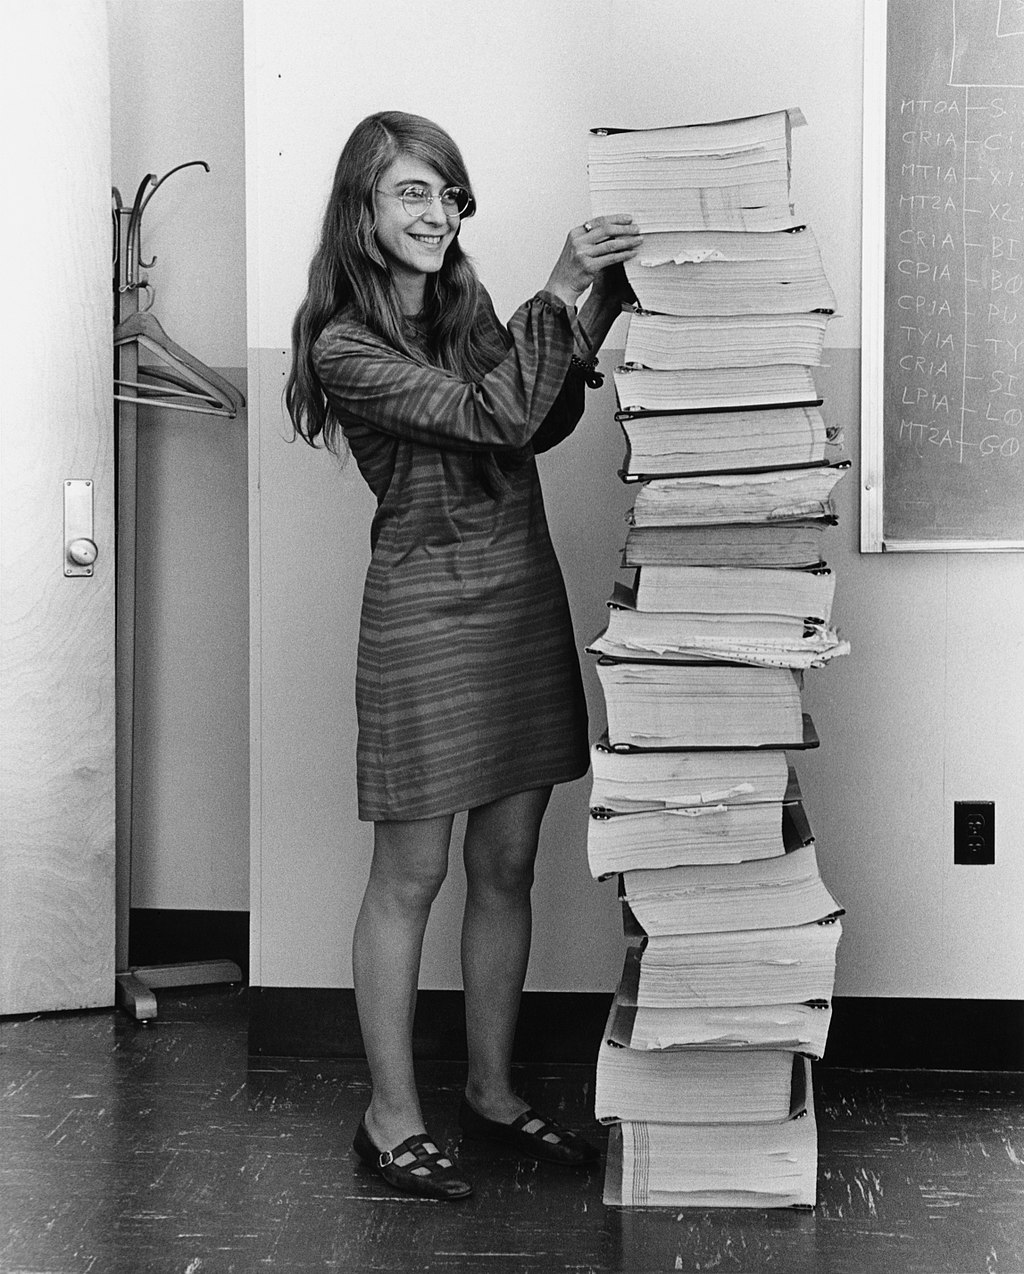

In [6]:
Image("mags.jpg", width=400)

It is tempting to look back at this computer system from our perspective and think of it as archaic and rudimentary. It was not. There were no computer hardware failures during Apollo flights, the system worked beautifully. It was designed to precisely the level of sophistication and capability that the missions required, and no more. It is an example of truly phenomenal engineering. The rest of this lecture is about how we design modern spacecraft avionics systems.

## Design Process

### 1. Allocate mission and system requirements

The design process for an avionics subsystem begins by establishing the functional and performance requirements of the subsystem. What must it do, and how well? At a systems-level, the functions that the avionics subsystem must perform include such things as:

1. Running flight software
2. Executing commands
3. Storing data
4. Processing data
5. Distributing data

In order to describe how well the avionics system must perform the above functions, we typically use metrics which include:

1. Throughput (instructions per second)
2. Data storage (ROM~kb, RAM~Mb, and Disk~Gb)
3. Radiation hardness (10krad LEO, 100 krad GEO, ~Mrad interplanetary)
4. Reliability/fault tolerance
5. Flexibility - the ability to change software after launch

It is not always trivial to estimate avionics requirements, since the avionics subsystem interfaces with so many aspects of the spacecraft. There is, however, a systematic strategy that we can use in order to estimate our requirements on the above metrics.

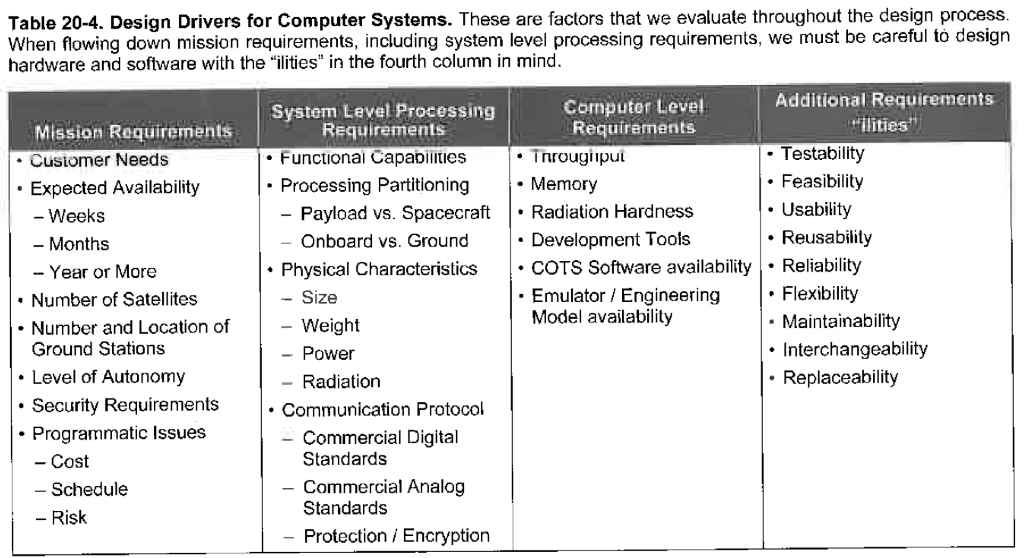

In [14]:
Image("drivers.png", width=600)

#### 1. List all applications and functions allocated to the computer

In order to generate avionics requirements, begin by listing every function that the computer must serve. A non-exhaustive list of such functions includes:

1. **Payload**: pointing, on/off
2. **T&C**: telemetry and command processing
3. **Attitude/orbit sensor processing**: gyros, star trackers, sun sensors, etc.
4. **ADCS algorithms**: Kalman filters, orbit propagation, integration, etc.
5. **Attitude control processing**: thrusters, reaction wheels, torque coils, etc.
6. **Fault detection**: monitoring, identification, and correction
7. **Power management**: battery charging, solar array pointing
8. **Thermal management**: heaters, louvers, coolers, pointing
9. **Momentum management**: momentum wheels
10. **Utilities**: basic math functions, matrix algebra, time management, rotations

Each of these functions may fall into one of a few categories. It may be an **operating system function** which manages the computers resources and schedules application software. Or, it may be an **application**, which includes mission-specific software which does work required by the user or the mission rather than in support of the computer. The processing tasks may be **hard real-time**, whcih requires precise timing to achieve correct results and has severe consequences associated ith missing a time boundary (e.g. ADCS, telemetry). Or, the tasks may be **soft real-time** where it is required that the task is performed in a timely manner, but missing a time boundary only results in degraded (but continuous) performance. Examples include orbit control, orientation of solar panels, and payload management.

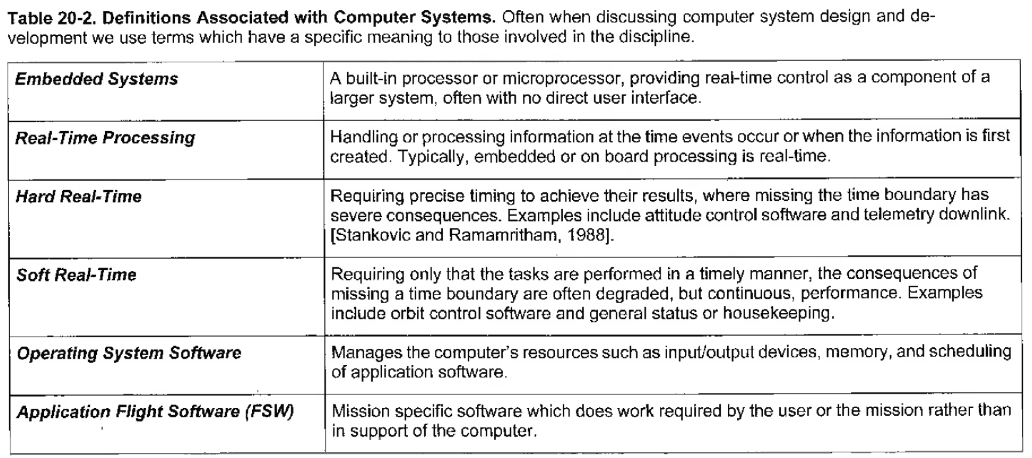

In [17]:
Image("terms.png", width=600)

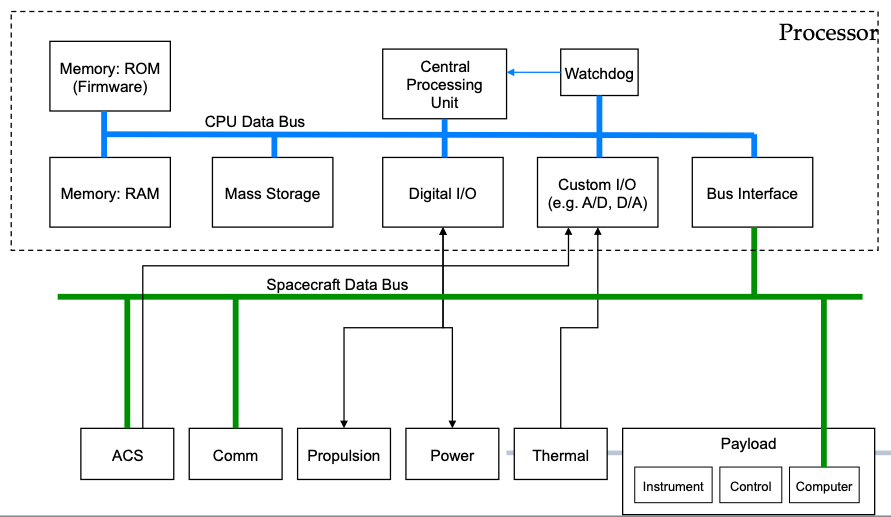

In [8]:
Image("schem.png", width=600)

#### 2. Estimate memory space requirement

For each of the functions that the avoinics system must perform, estimate the memory that is required for that function. This is accomplished either by analogy or through a bottom-up estimate.

#### 3. Estimate throughput

For each function, determine the frequency of the function (how many times must that function execute per second). Then, esimate the number of instructions per execution, and the number of cycles per instruction. This yields an estimate for the total number of required cycles per second.

#### 4. List all utility functions, determine OS requirements

Determine requirements for concurrent processes, interrupts, realtime tasks, etc.

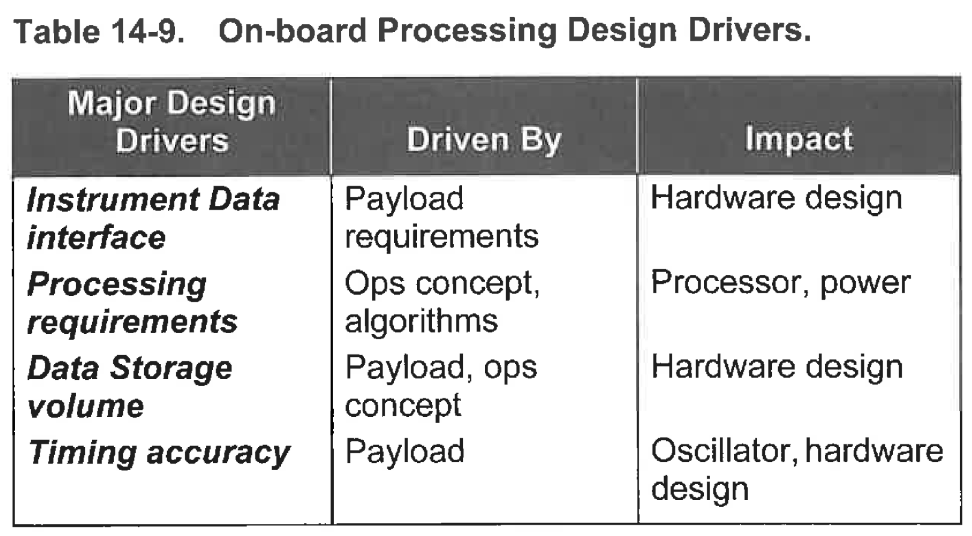

In [15]:
Image("pdrive.png", width=400)

#### 5. Determine margins for growth/spare capacity

Pictured below is a conceptual example of a throughput estimate.

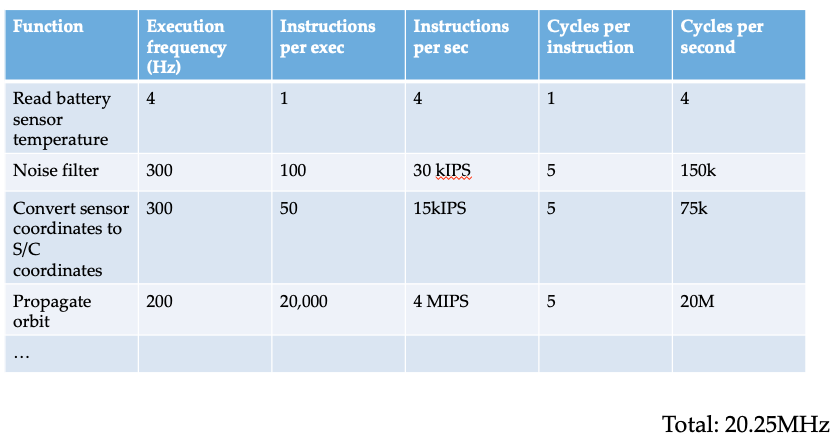

In [10]:
Image("tput.png", width=600)

### 2. Define the computer system's operational modes and states

Develop a state diagram consistent with the functional requirements, modeling different operational stages as different states. Make certain that degradation/failure states are modeled, and consider the effects on ground/ops for all states.

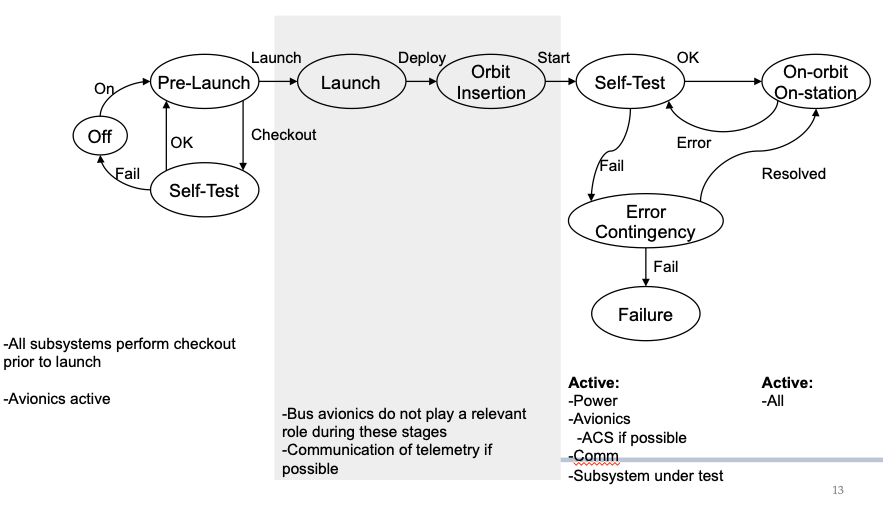

In [12]:
Image("states.png", width=600)

### 3. Functionally partition and allocate the computational requirements

Decide what part of the system architecture will be responsible for each computational requirement. For example, consider allocating functions to space vs. ground, payload, the spacecraft bus, or other subsystems. Distinguish between hardware and software requirements.

### 4. Evaluate internal and external interfaces

Determine input/output requirements for the avionics subystem with respect to the other subsystems and payload.

### 5. Select baseline architecture

Will your system use centralized or distributed processing? If distributed, what type? Do you need redundancy?

### 6. Form the baseline system specification

Create a detailed design and integration, assembly & test strategy.

## Technologies

### Memory

Memory comes in a variety of flavors. Each provides a means of storing data (1's and 0's).

#### Read-only memory (ROM)

Read-only memory is (as the name suggests) read only. It is non-volatile, which means that the data remains regardless of power or reset. Writing to this memory is very slow, so it interfaces with the CPU for only for read purposes (storing lookup tables, storing program information, etc). Usually, read-only memory is dedicated to "firmware," or software which will not change, though it is often the case that this memory can be reprogrammed with special instructions or different voltages. 

#### Random access memory (RAM)

This memory is volatile, which means that data is lost when power is removed and/or reset. It is also fast, up to over 1000 MHz. This is the memory that your software uses to store variables while you're doing math, temporarily store sensor readings, etc. Random Access Memories is also a good album by Daft Punk.

#### Non-volatile random access memory (NVRAM)

This memory is non-volatile, just like ROM, but you can both write to it and read from it. This memory will often store "software/firmware" that is expected to be updated, but otherwise does not change during normal operations. Flash memory is an example of this.

From a reliability standpoint, it is a good idea to make your spacecraft remotely reprogrammable. One way to do that is to store a bootloader in ROM, and store the program in NVRAM so that it can be rewritten. The chipsats are capable of this.

In [18]:
HTML("""
    <video alt="test" controls>
        <source src="wireless.mp4" type="video/mp4">
    </video>
""")

### Payload Mass Data Storage

#### Hard disk

Hard discs are based on mechanical/magnetic rotating discs. These are the most common available technologies with the largest storage capacities, though they are not without concern. Concerns surround reliability, angular momentum, and vibration.

#### Magnetic/optical/digital tapes (old)

These are based on a rotating mechanical system and offer highly reliable data storage. They are, however, based on a stack structure (first in, last out) which leads to slow data access. Normally this slow data access makes this sort of memory unuseful for operating systems or programs. They also bring concerns associated with momentum, start/stop torques, and vibration.

#### Bubble memory (old)

These are solid state and non-volatile with no moving parts. Patterns in magnetic permalloy and rotating magnetic field cause bubbles to move under read/write head. The daa persists in a magnetic field bias, but it is also high mass, has lots of power dissipation, and leads to unwanted magnetic fields.

#### Solid-state drives that use flash memory

Most common today.

#### Can you think of any additional, perhaps bizarre methods for storing data?

### Input/Output

#### Data bus

The spacecraft data bus is reserved for high-speed data transfers (>33MHz --> >500 Mbps). This will include the processor bus and the spacecraft bus, each of which may by 16-64 bits wide. The data bus connects all subsystems that generate and receive data/commands, and is connected to the communications subystem for external communication of that data.

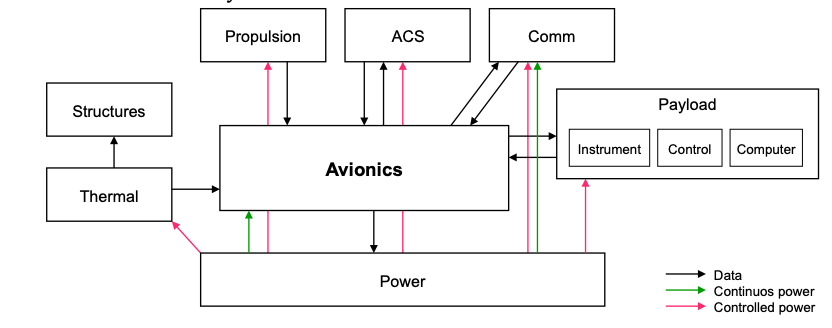

In [19]:
Image("bus.png", width=600)

#### Digital I/O

Usually, digital I/O is interface through the processor bus directly to the CPU. For mapped I/O, the CPU program may directly address these I/O ports. This enables direct control of parallel digital signals at low bandwidth (usually 1 bit - 1 byte at a time, though you can have custom size).

#### Custom I/O

Includes things like analog to digital converters, and specialized ports (UART, I2C, USB, etc).

### Processors

#### Microcontrollers (MCU)

These are small, dedicated processors for performing very specific tasks (interfacing with a single sensor, for example, or actuating a valve). They run at 1-100 MHz, \<16MB RAM, ROM storage (no HD/mass storage)

#### Digital signal processors (DSP)

Specifically designed to manage embedded digital systems, and have a high processing/power radio (e.g. 1 GIPS @ 6W). These typically run 100-1000 MHz, 16-2000 MB RAM, ROM storage, and FLASH storage.

#### Microprocessor ($\mu$P)

Powerful processors, with with a high power consumption. >1 GIPS, 50-200W, 4GB+RAM, ROM storage, HD's, CD-ROM's, etc. These have a general purpose instruction set.

## Reliability

Reliability requirements can be implemented via a few means, including:

1. Redundancy
2. Distributed processing
3. Watchdogs
4. Modularized memory
5. Replicate startup ROMs
6. Error detection and correction
7. Radiation hardness

Let us zoom in on a couple of these options in particular.

### Centralized Processing

One processor is designated as the master unit which provides all housekeeping and data handling. All commands are processed and routed through this central unit.

### Distributed Processing

Multiple processors divide the avionics tasks. There are two possible configurations: **distributed computing** and **redundant processing**. In distributed computing, executive tasks are shared by all processors, and dedicated processors are assigned to each subsystem. All of these processors communicate over the spacecraft bus. In redundant processing, multiple processors can assume the role of masters. This architecture tolerates faults well.

### Radiation hardness

Radiation of various sorts can have a variety of effects on avionics. Particle momentum, EM fields, and electrostatic charges can all affect onboard electronics.

High energy neutrons can cause structural damage in solid state materials.

Charge on gates of metal-oxide semiconductors can change their state for single event upsets (SEU's). This can unintentionally reconfigure magnetic components like hard disks and ROM.

High energy charged particles generate clouds of electrical charges. These charges slow down digital logic, change opamp offset voltages, reduce current capability, and can latch CMOS gates.

To protect against this, electronics components are covered with radiation resistant materials. Some components will even be re-designed to a more fault-tolerant architecture.

### Testing

Avionics are always tested bottom-up. The lowest level hardware/software is tested individually, and are only integrated after module/coponent testing.

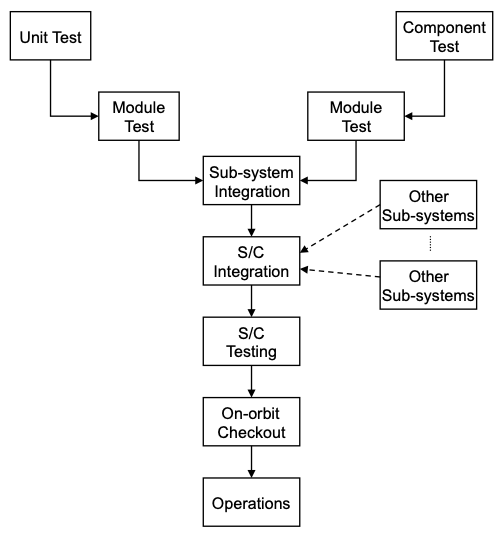

In [21]:
Image("testing.png", width=400)

## What can go wrong?

#### Tin Whiskers

An old problem is "tin whiskers." By means that are not well understood, pure tin and zinc can form "whiskers," dendritic crystal growths which can cause short circuits. To prevent this from happening, NASA now avoids using pure tin or zinc solder.

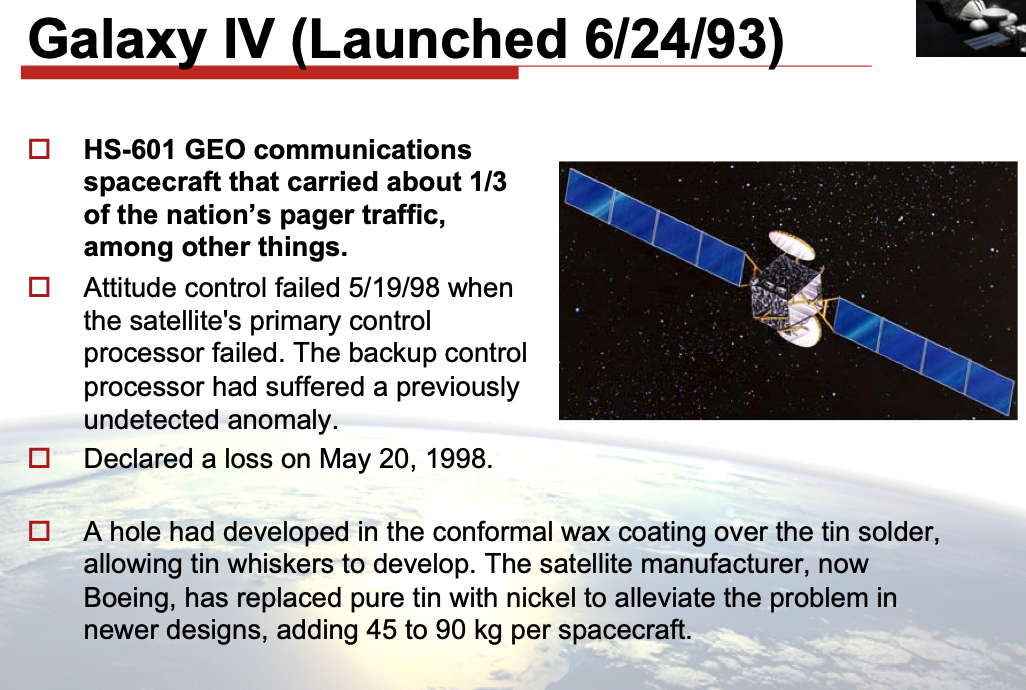

In [22]:
Image("loss.png", width=600)

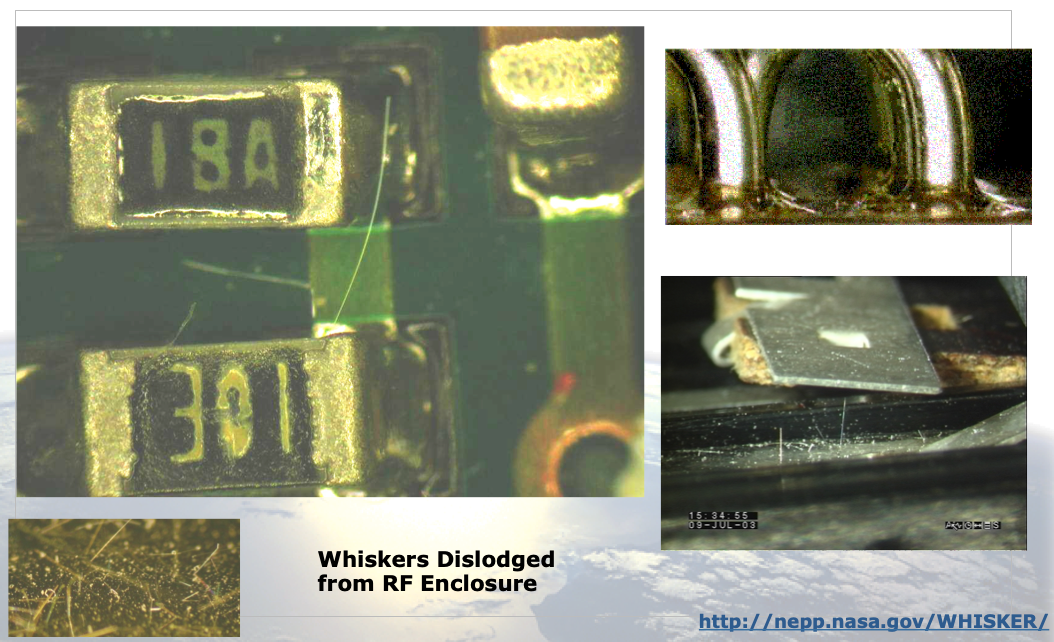

In [23]:
Image("whisker.png", width=600)

#### Electrostatic discharge

As you walk around, you accumulate static charge on your body. Sometimes, this static charge is removed quickly and painfully when you touch a doorknob, though often these discharges are small enough to be undetectable by feel.

Your electronics can feel it, however. If you don't maintain a ground connection (via ESD wriststraps), it is very possible that a static discharge from your body to the electronics that you're working on will destroy those electronics.